# Import

In [1]:
# !pip install imbalanced-learn
import imblearn
print(imblearn.__version__)

0.12.4


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns
import statistics
import math as m

# import necessary packages
import pandas as pd
from copy import deepcopy as copy
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch import save as torch_save
from sklearn import datasets
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix

# MODEL CREATION
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# RNN: data set-up

## EDA

In [4]:
region = 14
data_dir = "/content/drive/MyDrive/MS thesis"
x = f"/content/drive/MyDrive/MS thesis/preliminary site selection/RG{region}/rg{region}_clusters.csv"
rg1n_clustered_df = pd.read_csv(x)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0.0,0,...,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0.0,0,...,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0.0,0,...,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0.0,0,...,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1.0,0,...,2945473,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1.0,0,...,3036709,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1.0,0,...,3036709,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1.0,0,...,3036709,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1.0,0,...,3036709,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0


## Balance data
- this is so the model is properly trained with a more distributed set of data with 0s and 1s.


1. Downsampling data: to remove unbuildable areas
2. Dataframe set up: normalizing data
3. Upsampling data: generate data points with '1' label (just to teach the model)
4. Get low accessible areas (to turn into Candidate Sites)


### Downsampling

In [5]:
print(rg1n_clustered_df.shape)
print(rg1n_clustered_df['RHU_Presence'].unique())
print(rg1n_clustered_df['Cluster'].unique())
buildable = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
buildable

(8036, 22)
[0 1]
[0 1]


,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
100,100,2945473,Labaan,San Quintin,Abra,1.316676,0.086427,1.328766,0.0,1,...,2945473,0.0,60.755378,69.986885,745.277266,369.171842,184.473551,147.041397,0.395150,0
266,266,2949695,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0.0,1,...,2949695,0.0,1064.043944,461.590338,9934.919310,4948.307374,2839.042008,2127.815156,0.536488,0
267,267,2949696,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0.0,1,...,2949696,0.0,177.832150,87.036106,1673.199458,825.388536,465.459534,358.513692,0.464459,0
401,401,2952458,Camdas Subdivision,City of Baguio,Benguet,0.211514,1.075451,0.748432,0.0,1,...,2952458,0.0,3281.737645,2094.145067,35223.939879,18052.295636,10667.293964,8003.527819,0.518334,0
479,479,2953840,Abanao-Zandueta-Kayong-Chugum-Otek (AZKCO),City of Baguio,Benguet,0.203671,1.103190,0.750000,0.0,1,...,2953840,0.0,2398.091662,1863.104340,31530.203824,16465.908709,10578.946669,9411.051527,0.518680,0
480,480,2953841,DPS Area,City of Baguio,Benguet,0.200014,1.103190,0.738017,0.0,1,...,2953841,0.0,2983.775492,1783.243971,29991.521535,15418.263916,9135.950923,6579.663673,0.521317,0
559,559,2955222,Lopez Jaena,City of Baguio,Benguet,0.202084,1.083951,0.726514,0.0,1,...,2955222,0.0,1942.892595,1565.668608,22947.032542,11879.529796,7131.748760,5751.979915,0.481148,0
561,561,2955224,Greenwater Village,City of Baguio,Benguet,0.201281,1.081863,0.738003,0.0,1,...,2955224,0.0,741.157007,571.068003,8168.563193,4133.120631,2371.514344,1701.041490,0.541301,0
562,562,2955225,Apugan-Loakan,City of Baguio,Benguet,0.189809,1.187180,0.711384,0.0,1,...,2955225,0.0,1274.845467,639.785692,12797.327891,6545.017529,3933.217018,2718.882289,0.536876,0
727,727,2957983,Shilan,La Trinidad,Benguet,0.212637,1.084002,0.729452,0.0,1,...,2957983,0.0,144.278295,69.791869,1355.150027,647.843245,353.653391,289.182054,0.468271,0


In [6]:
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True) # DROP NANS so it doesnt interfere with the pcf calculations
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int) # CONVERT LAND COV COL INTO INT FROM FLOAT
high_clustered = rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 1]
high_clustered['buildability_landcov'].unique()
rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 0]

''' If ever non buildable values come out for clusters with 1, change their values to buildable '''
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [1]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [1]
# Filter rows with clusters of size 1
df_filtered = rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 1]

if not df_filtered.empty:
    # Use loc[] for index-based updates
    df_filtered.loc[:, 'buildability_landcov'] = 1  # Update entire column with 1
    rg1n_clustered_df.update(df_filtered)
    print("Updated 'buildability_landcov' values to 1 for clusters with size 1.")
else:
    print("No clusters with size 1 found in the DataFrame.")
# print(rg1n_clustered_df)
rg1n_clustered_df

Updated 'buildability_landcov' values to 1 for clusters with size 1.


,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1,0,...,2945473,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,3036709,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,3036709,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0


In [7]:
'''DROP NON-BUILDABLE AREAS
>> dont do this anymore
'''
non_buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 0]
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['buildability_landcov'] == 0], inplace = True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1,0,...,2945473,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,3036709,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,3036709,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0


In [8]:
print(rg1n_clustered_df)
print(non_buildable)
print(rg1n_clustered_df['RHU_Presence'].unique())
non_buildable

      Unnamed: 0       ID barangay_name      city_name province_name  \
0              0  2937258   San Pascual           Tuba       Benguet   
1              1  2938639   San Pascual           Tuba       Benguet   
2              2  2938640   San Pascual           Tuba       Benguet   
3              3  2938641   San Pascual           Tuba       Benguet   
4              4  2939947      Tangadan    San Quintin          Abra   
...          ...      ...           ...            ...           ...   
8031        8031  3060187     Romualdez  Rizal (Liwan)       Kalinga   
8032        8032  3061563      Calaocan  Rizal (Liwan)       Kalinga   
8033        8033  3061564        Santor  Rizal (Liwan)       Kalinga   
8034        8034  3061565        Santor  Rizal (Liwan)       Kalinga   
8035        8035  3061566        Santor  Rizal (Liwan)       Kalinga   

      flood_probability_value  rain intensity_value  drought_value  \
0                    0.660628              1.040006       1.01622

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0
6,6,2940014,Poblacion,Sablan,Benguet,0.548451,0.993987,1.064979,0,0,...,2949695,13.942798,58.546597,49.757376,631.101639,313.720687,166.664575,113.676122,0.452927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8013,8013,3058796,San Quintin,Rizal (Liwan),Kalinga,0.982826,1.096958,1.303478,0,0,...,3036709,46.586953,7.716591,4.341136,64.423572,31.313228,16.911229,14.118420,0.356296,0
8014,8014,3058797,San Quintin,Rizal (Liwan),Kalinga,0.982826,1.096958,1.303478,0,0,...,3036709,45.375587,29.575413,17.015202,245.960253,114.482466,59.937660,54.418545,0.366983,0
8015,8015,3058798,Babalag East (Pob.),Rizal (Liwan),Kalinga,0.899932,0.962861,1.314431,0,0,...,3036709,43.953477,7.404268,6.707876,76.128120,37.494324,20.111868,15.276552,0.360747,0
8016,8016,3058799,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,0,0,...,3036709,42.547834,43.398784,36.740041,429.690612,211.890445,113.561578,83.218122,0.420908,0


In [9]:
rg1n_clustered_df = rg1n_clustered_df.reset_index(drop=True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1,0,...,2945473,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,3036709,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,3036709,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,3036709,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0


### DF Set-up
- Data is normalized

In [10]:
rg1n_clustered_df.columns

Index(['Unnamed: 0', 'ID', 'barangay_name', 'city_name', 'province_name',
       'flood_probability_value', 'rain intensity_value', 'drought_value',
       'buildability_landcov', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'Nearest_RHU', 'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld',
       'popden_all', 'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI',
       'Cluster'],
      dtype='object')

In [11]:
'''AGGREGATING THE POPULATION'''
# Assuming df is your DataFrame
vp =  rg1n_clustered_df['popden_chi'] + rg1n_clustered_df['popden_eld'] + rg1n_clustered_df['popden_wom'] + rg1n_clustered_df['popden_you'] + rg1n_clustered_df['popden_w_1'] + rg1n_clustered_df['popden_you']
gen = rg1n_clustered_df['popden_all'] - vp
all = vp + gen
rg1n_clustered_df['total_population'] = all
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0,42.700084
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0,22.531374
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1,0,...,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0,12.261030
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0,26.974266
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0,22.014504


In [12]:
rg1n_clustered_df.loc[rg1n_clustered_df['total_population'] == 0]
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True)
# x_normalized.dropna(inplace=True)

# Convert column 'x14' from float to int
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,0,2937258,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,1,2938639,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0,42.700084
2,2,2938640,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,3,2938641,San Pascual,Tuba,Benguet,0.660628,1.040006,1.016222,0,0,...,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0,22.531374
4,4,2939947,Tangadan,San Quintin,Abra,0.889123,0.085881,1.329499,1,0,...,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0,12.261030
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0,26.974266
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0,22.014504


In [13]:
numeric_rg1_clustered_df = rg1n_clustered_df.drop(['barangay_name', 'city_name', 'province_name', 'Unnamed: 0'], axis=1)
numeric_rg1_clustered_df

,ID,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,2937258,0.660628,1.040006,1.016222,0,0,0,0,2949695,11.881194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
1,2938639,0.660628,1.040006,1.016222,0,0,0,0,2949695,10.521039,4.463704,3.074064,42.700084,20.802600,10.990840,9.390640,0.384188,0,42.700084
2,2938640,0.660628,1.040006,1.016222,0,0,0,0,2949695,10.795344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
3,2938641,0.660628,1.040006,1.016222,0,0,1,0,2949695,11.184976,2.169792,2.414076,22.531374,11.466858,5.618472,4.195896,0.447876,0,22.531374
4,2939947,0.889123,0.085881,1.329499,1,0,0,0,2945473,6.613961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,3060187,0.796756,1.049184,1.303862,1,0,0,0,3036709,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8032,3061563,0.928698,0.982442,1.309814,1,0,0,0,3036709,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0,12.261030
8033,3061564,0.883437,1.023447,1.311747,1,0,0,0,3036709,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0,26.974266
8034,3061565,0.883437,1.023447,1.311747,1,0,0,0,3036709,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0,22.014504


In [14]:
# df1[df1['RHU_Presence']==0]
# Count the number of unique values in column 'A'
unique_count = numeric_rg1_clustered_df['Cluster'].nunique()
print("Number of unique values in column 'Cluster':", unique_count)

Number of unique values in column 'Cluster': 2


In [15]:
numeric_rg1_clustered_df.Cluster.unique()
df1 = numeric_rg1_clustered_df[numeric_rg1_clustered_df.isna().any(axis=1)]

df1.loc[df1['RHU_Presence'] == 1, 'buildability_landcov'] = 1
numeric_rg1_clustered_df.loc[numeric_rg1_clustered_df['RHU_Presence'] == 1, 'buildability_landcov'] = 1 # CHANGING AREAS WITH RHUS HAVE A BUILDABILITY SCORE OF 1

In [16]:
# Making id_template for retrieving hex id numbers in the future
id_template = numeric_rg1_clustered_df.astype({'ID' : 'int'})
id_template = id_template.filter(['ID'])
# id_template
y_sample_id = numeric_rg1_clustered_df.filter(['ID', 'Cluster'])
y_sample_id

,ID,Cluster
0,2937258,0
1,2938639,0
2,2938640,0
3,2938641,0
4,2939947,0
...,...,...
8031,3060187,0
8032,3061563,0
8033,3061564,0
8034,3061565,0


In [17]:
y_sample_id[y_sample_id["Cluster"] == 0]

,ID,Cluster
0,2937258,0
1,2938639,0
2,2938640,0
3,2938641,0
4,2939947,0
...,...,...
8031,3060187,0
8032,3061563,0
8033,3061564,0
8034,3061565,0


In [18]:
for i in numeric_rg1_clustered_df.columns:
  print(i)

ID
flood_probability_value
rain intensity_value
drought_value
buildability_landcov
RHU_Presence
Road_Presence
POI_Presence
Nearest_RHU
Distance_to_Nearest_RHU_km
popden_chi
popden_eld
popden_all
popden_wom
popden_w_1
popden_you
HCFAI
Cluster
total_population


In [19]:
x = numeric_rg1_clustered_df.loc[:, ~numeric_rg1_clustered_df.columns.isin(['ID', 'RHU_Presence', 'buildability_landcov',
                                                                            'POI_Presence', 'Road_Presence', 'Nearest_RHU',
                                                                            'Cluster'
                                                                            ])]
x_normalized = (x - x.min()) / (x.max() - x.min())
x_normalized

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population
0,0.433884,0.337897,0.702149,0.097007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000
1,0.433884,0.337897,0.702149,0.085901,0.001300,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062
2,0.433884,0.337897,0.702149,0.088141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000
3,0.433884,0.337897,0.702149,0.091322,0.000632,0.001069,0.000560,0.000554,0.000426,0.000374,0.351942,0.000560
4,0.603034,0.000000,0.947398,0.054001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.534657,0.341148,0.927329,0.292260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000
8032,0.632331,0.317511,0.931988,0.355514,0.000447,0.000342,0.000305,0.000294,0.000241,0.000237,0.390088,0.000305
8033,0.598825,0.332033,0.933502,0.347992,0.000984,0.000753,0.000671,0.000646,0.000531,0.000521,0.393686,0.000671
8034,0.598825,0.332033,0.933502,0.337080,0.000783,0.000578,0.000547,0.000518,0.000429,0.000442,0.393686,0.000547


In [20]:
x_normalized['RHU_Presence'] = numeric_rg1_clustered_df['RHU_Presence']
x_normalized['ID'] = numeric_rg1_clustered_df['ID']
x_normalized['buildability_landcov'] = numeric_rg1_clustered_df['buildability_landcov']
x_normalized['Road_Presence'] = numeric_rg1_clustered_df['Road_Presence']
x_normalized['POI_Presence'] = numeric_rg1_clustered_df['POI_Presence']
x_normalized['Nearest_RHU'] = numeric_rg1_clustered_df['Nearest_RHU']
# x_normalized['Neighbors'] = numeric_rg1_clustered_df['Neighbors']
x_normalized['Cluster'] = numeric_rg1_clustered_df['Cluster']
all_normalized = x_normalized
all_normalized.head()

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.433884,0.337897,0.702149,0.097007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695,0
1,0.433884,0.337897,0.702149,0.085901,0.001300,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695,0
2,0.433884,0.337897,0.702149,0.088141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695,0
3,0.433884,0.337897,0.702149,0.091322,0.000632,0.001069,0.000560,0.000554,0.000426,0.000374,0.351942,0.000560,0,2938641,0,1,0,2949695,0
4,0.603034,0.000000,0.947398,0.054001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2939947,1,0,0,2945473,0


In [21]:
x_normalized = x_normalized.drop(['Cluster'], axis=1)
x_normalized

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU
0,0.433884,0.337897,0.702149,0.097007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695
1,0.433884,0.337897,0.702149,0.085901,0.001300,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695
2,0.433884,0.337897,0.702149,0.088141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695
3,0.433884,0.337897,0.702149,0.091322,0.000632,0.001069,0.000560,0.000554,0.000426,0.000374,0.351942,0.000560,0,2938641,0,1,0,2949695
4,0.603034,0.000000,0.947398,0.054001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2939947,1,0,0,2945473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.534657,0.341148,0.927329,0.292260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,3060187,1,0,0,3036709
8032,0.632331,0.317511,0.931988,0.355514,0.000447,0.000342,0.000305,0.000294,0.000241,0.000237,0.390088,0.000305,0,3061563,1,0,0,3036709
8033,0.598825,0.332033,0.933502,0.347992,0.000984,0.000753,0.000671,0.000646,0.000531,0.000521,0.393686,0.000671,0,3061564,1,0,0,3036709
8034,0.598825,0.332033,0.933502,0.337080,0.000783,0.000578,0.000547,0.000518,0.000429,0.000442,0.393686,0.000547,0,3061565,1,0,0,3036709


In [22]:
y_df = numeric_rg1_clustered_df['Cluster'].values
y_df

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
num_features = len(x_normalized.columns)
print("Number of Features: {}".format(num_features))

Number of Features: 18


In [24]:
columns = []
for i in range(num_features):
    columns.append("x{}".format(i))

x_normalized.columns = columns # replacing the name of the columns
x_normalized

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
0,0.433884,0.337897,0.702149,0.097007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695
1,0.433884,0.337897,0.702149,0.085901,0.001300,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695
2,0.433884,0.337897,0.702149,0.088141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695
3,0.433884,0.337897,0.702149,0.091322,0.000632,0.001069,0.000560,0.000554,0.000426,0.000374,0.351942,0.000560,0,2938641,0,1,0,2949695
4,0.603034,0.000000,0.947398,0.054001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2939947,1,0,0,2945473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.534657,0.341148,0.927329,0.292260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,3060187,1,0,0,3036709
8032,0.632331,0.317511,0.931988,0.355514,0.000447,0.000342,0.000305,0.000294,0.000241,0.000237,0.390088,0.000305,0,3061563,1,0,0,3036709
8033,0.598825,0.332033,0.933502,0.347992,0.000984,0.000753,0.000671,0.000646,0.000531,0.000521,0.393686,0.000671,0,3061564,1,0,0,3036709
8034,0.598825,0.332033,0.933502,0.337080,0.000783,0.000578,0.000547,0.000518,0.000429,0.000442,0.393686,0.000547,0,3061565,1,0,0,3036709


In [25]:
y_df = pd.DataFrame(y_df, columns = ['Y_Cluster'])

print(y_df)
print(type(y_df))

      Y_Cluster
0             0
1             0
2             0
3             0
4             0
...         ...
8031          0
8032          0
8033          0
8034          0
8035          0

[8036 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


### Upsampling
- use smote to generate data points with '1' (high level) -- for training only!

In [26]:
y_sample = numeric_rg1_clustered_df['Cluster']
y_sample.unique()
rg1n_clustered_df['buildability_landcov'] == 1
# summarize the new class distribution
counter = Counter(y_sample)
print(counter)
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [0]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [0]
x_normalized = x_normalized.drop(['x13', 'x17'], axis=1)

Counter({0: 6854, 1: 1182})


In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
SS = {1: int(0.7 * len(y_sample))}
# SS = {1: len(y_sample)}
oversample = SMOTE(sampling_strategy=SS, k_neighbors=1)
# oversample = SMOTE(k_neighbors=1)
x_normalized, y_sample = oversample.fit_resample(x_normalized, y_sample)

## Another sampling technique
# Create a pipeline with RandomUnderSampler and SMOTE
# pipeline = Pipeline([
#     ('under_sampling', RandomUnderSampler(sampling_strategy=0.5)),  # Undersample the majority class to 50%
#     ('sampling', SMOTE())  # Apply SMOTE to balance the classes
# ])
# Apply the pipeline to the training data
# X_resampled, y_resampled = pipeline.fit_resample(x_normalized, y_sample)


counter_resampled = Counter(y_sample)
print(f"After resampling: {counter_resampled}")

After resampling: Counter({0: 6854, 1: 5625})


### filtered_low_accessible_df

In [28]:
from pathlib import Path
filepath = Path(f'/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/all_normalized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
all_normalized.to_csv(filepath, index=False)

In [29]:
all_normalized_df = pd.read_csv(data_dir + f'/[optimize] Training, Testing/RG{region}/all_normalized.csv')
all_normalized_df.head(3)

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.433884,0.337897,0.702149,0.097007,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695,0
1,0.433884,0.337897,0.702149,0.085901,0.0013,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695,0
2,0.433884,0.337897,0.702149,0.088141,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695,0


In [30]:
filtered_low_accessible_df = pd.concat([all_normalized], axis=1)
filtered_low_accessible_df = filtered_low_accessible_df[filtered_low_accessible_df['Cluster'] == 0]
filtered_low_accessible_df.head(3)

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.433884,0.337897,0.702149,0.097007,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695,0
1,0.433884,0.337897,0.702149,0.085901,0.0013,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695,0
2,0.433884,0.337897,0.702149,0.088141,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695,0


In [31]:
# hex_neighbors = filtered_low_accessible_df[['ID', 'Neighbors']]
# hex_neighbors

In [32]:
filtered_low_accessible_x = filtered_low_accessible_df.drop(['Cluster'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.dropna()

In [33]:
# filtered_low_accessible_x = filtered_low_accessible_x.drop(['ID', 'Neighbors', 'Nearest_RHU'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.drop(['ID', 'Nearest_RHU'], axis=1)
filtered_low_accessible_df['Cluster'] = filtered_low_accessible_df['Cluster'].astype('int')
filtered_labels_y = filtered_low_accessible_df['Cluster']
filtered_labels_y

,Cluster
0,0
1,0
2,0
3,0
4,0
...,...
8031,0
8032,0
8033,0
8034,0


In [34]:
filtered_low_accessible_df

,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Cluster
0,0.433884,0.337897,0.702149,0.097007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2937258,0,0,0,2949695,0
1,0.433884,0.337897,0.702149,0.085901,0.001300,0.001362,0.001062,0.001005,0.000834,0.000838,0.166359,0.001062,0,2938639,0,0,0,2949695,0
2,0.433884,0.337897,0.702149,0.088141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2938640,0,0,0,2949695,0
3,0.433884,0.337897,0.702149,0.091322,0.000632,0.001069,0.000560,0.000554,0.000426,0.000374,0.351942,0.000560,0,2938641,0,1,0,2949695,0
4,0.603034,0.000000,0.947398,0.054001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,2939947,1,0,0,2945473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,0.534657,0.341148,0.927329,0.292260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503830,0.000000,0,3060187,1,0,0,3036709,0
8032,0.632331,0.317511,0.931988,0.355514,0.000447,0.000342,0.000305,0.000294,0.000241,0.000237,0.390088,0.000305,0,3061563,1,0,0,3036709,0
8033,0.598825,0.332033,0.933502,0.347992,0.000984,0.000753,0.000671,0.000646,0.000531,0.000521,0.393686,0.000671,0,3061564,1,0,0,3036709,0
8034,0.598825,0.332033,0.933502,0.337080,0.000783,0.000578,0.000547,0.000518,0.000429,0.000442,0.393686,0.000547,0,3061565,1,0,0,3036709,0


In [35]:
duplicates = filtered_low_accessible_df[filtered_low_accessible_df.duplicated(['ID', 'Cluster'])]
print(duplicates)

Empty DataFrame
Columns: [flood_probability_value, rain intensity_value, drought_value, Distance_to_Nearest_RHU_km, popden_chi, popden_eld, popden_all, popden_wom, popden_w_1, popden_you, HCFAI, total_population, RHU_Presence, ID, buildability_landcov, Road_Presence, POI_Presence, Nearest_RHU, Cluster]
Index: []


In [36]:
y_filtered_labels_id = filtered_low_accessible_df[['ID', 'Cluster']]
y_filtered_labels_id

,ID,Cluster
0,2937258,0
1,2938639,0
2,2938640,0
3,2938641,0
4,2939947,0
...,...,...
8031,3060187,0
8032,3061563,0
8033,3061564,0
8034,3061565,0


In [37]:
y_filtered_labels_id[y_filtered_labels_id['Cluster'] == 1]

,ID,Cluster


# RNN: model set-up

## Split and convert Dataset to DataLoader
> For neural network compatibility

In [38]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

In [39]:
train_df, test_df = train_test_split(all_normalized_df, test_size=0.3)

## Model Creation
> The model was created with the following parameters:
- number of layers: x
- The model was created to be a classifier to distinguish buildable and non-buildable areas in a region. Buildable areas will become candidate sites

Hyperparameters of developing a BPNN:
1. Loss
2. Number of Layers
3. Optimizer Function
4. Activation Function
5. Batch Size
6. Scheduler

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int, batch_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state=None) -> tuple[torch.Tensor, torch.Tensor]:
        if hidden_state is None:
            hidden_state = self.init_zero_hidden(x.size(0))

        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
				Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

# Define input, hidden, and output sizes
input_size = 16  # Example input size (this should be your actual input feature size)
hidden_size = 256
output_size = 2   # Number of output classes
num_layers = 6    # Number of RNN layers
batch_size = 16
# Create the RNN model
model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
print(model)

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adjust learning rate as needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training function
def train(k, epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        hidden_state = model.init_zero_hidden(batch_size=X.size(0))
        outputs, _ = model(X, hidden_state)
        loss = criterion(outputs, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Update learning rate based on validation loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss_values.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Testing function
def test(k, epoch, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            hidden_state = model.init_zero_hidden(batch_size=X.size(0))
            # Forward pass
            pred, _ = model(X, hidden_state)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    test_average_loss_values.append(test_loss)
    test_accuracy_values.append(accuracy)
    print(f'Fold: {k+1} | Epoch {epoch+1}: | Loss: {(test_loss):.3f} | Acc: {accuracy:.3f}')
    return test_loss, accuracy

# Modify k_fold_splitter to accept batch size as a parameter
def k_fold_splitter(x, y, batch_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    # Splits X and Y tensors
    train_data = TrainData(x_train_tensor, y_train_tensor)
    test_data = TestData(x_test_tensor, y_test_tensor)
    # Data Loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    return train_loader, test_loader, x_test_tensor, y_test_tensor


global outter_all_train_loss
outter_all_train_loss = []

global outter_all_test_average_loss_values
outter_all_test_average_loss_values  = []

global outter_all_test_accuracy
outter_all_test_accuracy = []

global outter_all_pred_per_kfold
outter_all_pred_per_kfold = []

global outter_all_actual_per_kfold
outter_all_actual_per_kfold = []

global outter_actual_in_kfold
outter_actual_in_kfold = []

global outter_pred_in_kfold
outter_pred_in_kfold = []

global hexid_per_kfold
outter_hexid_per_kfold = []

global outter_train_loss_values
outter_train_loss_values = []

# global best_accuracy
folds = range(10)
best_accuracy = 0.0
best_model = None

# Add a list of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128]
best_accuracy_overall = 0.0
best_model_overall = None
best_k_overall = None
best_batch_size = None
best_batch_size_avg_collection = None

best_all_train_loss = None
best_all_test_average_loss_values = None
best_all_test_accuracy = None
best_all_pred_per_kfold = None
best_all_actual_per_kfold = None
best_actual_in_kfold = None
best_pred_in_kfold = None
best_hexid_per_kfold = None
best_train_loss_values = None

RNN(
  (i2h): Linear(in_features=16, out_features=256, bias=False)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)


# RNN model driver

In [41]:
for batch_size in batch_sizes:
    print(f"=================== Batch Size: {batch_size} ===================\n")
    all_train_loss = []
    all_test_average_loss_values  = []
    all_test_accuracy = []
    all_pred_per_kfold = []
    all_actual_per_kfold = []
    actual_in_kfold = []
    pred_in_kfold = []
    hexid_per_kfold = []
    train_loss_values = []

    for k in folds:
      train_loader, test_loader, x_test_tensor, y_test = k_fold_splitter(x_normalized, y_sample, batch_size)
      test_loss_values = []
      test_average_loss_values = []
      test_accuracy_values = []

      counter = 0  # Counter for consecutive epochs with no improvement
      prev_val_loss = float('inf')  # Initialize previous validation loss
      prev_accuracy = 0.0            # Initialize previous accuracy
      patience = 10  # Number of epochs with no improvement to wait before stopping

      # model = RNN(input_size, hidden_size, output_size, num_layers, batch_size).to(device)
      model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
      epochs = 250  # Change to best epoch if necessary
      print(f"=================== K = {k+1} ===================\n")

      for epoch in range(epochs):
          train(k, epoch, train_loader, model, criterion, optimizer)
          val_loss, val_accuracy = test(k, epoch, test_loader, model, criterion)
          if val_accuracy > best_accuracy:
              best_accuracy = val_accuracy
              best_k = k + 1
              print("BEST: ", best_accuracy)
              best_model = model.state_dict().copy()  # Save a copy of the model's state
              counter = 0  # Reset counter if there's improvement
          else:
              counter += 1
          if counter >= patience:
              print(f'No improvement for {patience} consecutive epochs. Stopping early.')
              break

      hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
      predictions, _ = model(x_test_tensor, hidden_state)
      predictions = F.softmax(predictions, dim=1)
      predictions = torch.argmax(predictions, dim=1)
      pred_in_kfold.append(predictions)
      actual_y = y_test  # actual y values per k-fold
      # loss
      all_train_loss.append(train_loss_values)
      all_test_average_loss_values.append(test_average_loss_values)
      all_test_accuracy.append(test_accuracy_values)  # accuracy
      # y pred and actual y
      actual_in_kfold.append(actual_y)
      all_pred_per_kfold.append(pred_in_kfold)
      all_actual_per_kfold.append(actual_y.tolist())

      if best_accuracy > best_accuracy_overall:
        best_accuracy_overall = best_accuracy
        best_model_overall = best_model
        best_k_overall = best_k
        best_batch_size = batch_size

        best_all_train_loss = all_train_loss
        best_all_test_average_loss_values = all_test_average_loss_values
        best_all_test_accuracy = all_test_accuracy
        best_all_pred_per_kfold = all_pred_per_kfold
        best_all_actual_per_kfold = all_actual_per_kfold
        best_actual_in_kfold = actual_in_kfold
        best_pred_in_kfold = pred_in_kfold
        best_hexid_per_kfold = hexid_per_kfold
        best_train_loss_values = train_loss_values

      print(f"BEST accuracy in {best_k}-fold: ")
      print(f"Saving... best_model with accuracy of {best_accuracy}")
      torch.save(best_model, f'/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/rnn_model.pt')

      print(f"Length of inner accuracies: {len(all_test_accuracy)}")

    outter_all_train_loss.append(all_train_loss)
    outter_all_test_average_loss_values.append(all_test_average_loss_values)
    outter_all_test_accuracy.append(all_test_accuracy)
    outter_all_pred_per_kfold.append(all_pred_per_kfold)
    outter_all_actual_per_kfold.append(all_actual_per_kfold)
    outter_actual_in_kfold.append(actual_in_kfold)
    outter_pred_in_kfold.append(pred_in_kfold)
    outter_hexid_per_kfold.append(hexid_per_kfold)
    outter_train_loss_values.append(train_loss_values)
    print(f"Length of outter accuracies: {len(outter_all_test_accuracy)}")

print(f"Overall best accuracy: {best_accuracy_overall}")
print(f"Best batch size: {best_batch_size}")
print(f"Best k-fold: {best_k_overall}")
print("Done!")

=================== Batch Size: 16 ===================

=================== K = 1 ===================

loss: 0.676789  [    0/ 8735]
loss: 0.672208  [ 1600/ 8735]
loss: 0.649332  [ 3200/ 8735]
loss: 0.687770  [ 4800/ 8735]
loss: 0.636894  [ 6400/ 8735]
loss: 0.675097  [ 8000/ 8735]
Fold: 1 | Epoch 1: | Loss: 0.671 | Acc: 60.550
BEST:  60.55021367521367
loss: 0.653486  [    0/ 8735]
loss: 0.679152  [ 1600/ 8735]
loss: 0.649700  [ 3200/ 8735]
loss: 0.705935  [ 4800/ 8735]
loss: 0.679342  [ 6400/ 8735]
loss: 0.674425  [ 8000/ 8735]
Fold: 1 | Epoch 2: | Loss: 0.671 | Acc: 60.550
loss: 0.657933  [    0/ 8735]
loss: 0.663541  [ 1600/ 8735]
loss: 0.668541  [ 3200/ 8735]
loss: 0.661332  [ 4800/ 8735]
loss: 0.677636  [ 6400/ 8735]
loss: 0.669418  [ 8000/ 8735]
Fold: 1 | Epoch 3: | Loss: 0.671 | Acc: 60.550
loss: 0.688397  [    0/ 8735]
loss: 0.678008  [ 1600/ 8735]
loss: 0.660085  [ 3200/ 8735]
loss: 0.677425  [ 4800/ 8735]
loss: 0.656645  [ 6400/ 8735]
loss: 0.686031  [ 8000/ 8735]
Fold: 1 | E

=============== K = 0 ================
              precision    recall  f1-score   support

           0       0.53      0.95      0.68      2027
           1       0.00      0.00      0.00      1717

    accuracy                           0.51      3744
   macro avg       0.26      0.47      0.34      3744
weighted avg       0.29      0.51      0.37      3744

MCC: -0.15556942662621884
F1: 0.6786659608258337
=============== K = 1 ================
              precision    recall  f1-score   support

           0       0.53      0.89      0.66      2088
           1       0.00      0.00      0.00      1656

    accuracy                           0.49      3744
   macro avg       0.26      0.44      0.33      3744
weighted avg       0.29      0.49      0.37      3744

MCC: -0.23203176399096165
F1: 0.6614229531641044
=============== K = 2 ================
              precision    recall  f1-score   support

           0       0.18      0.06      0.09      2070
           1       0.3

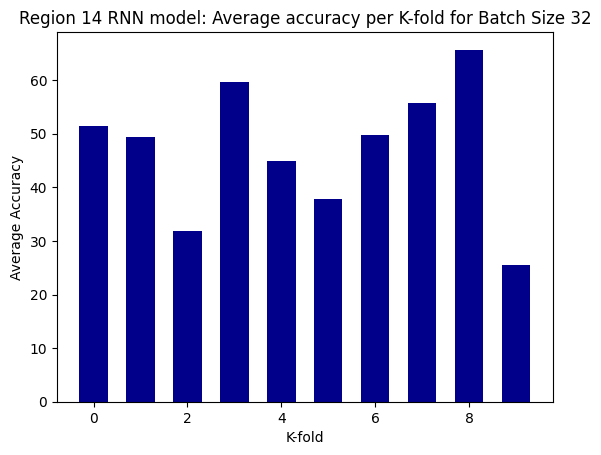

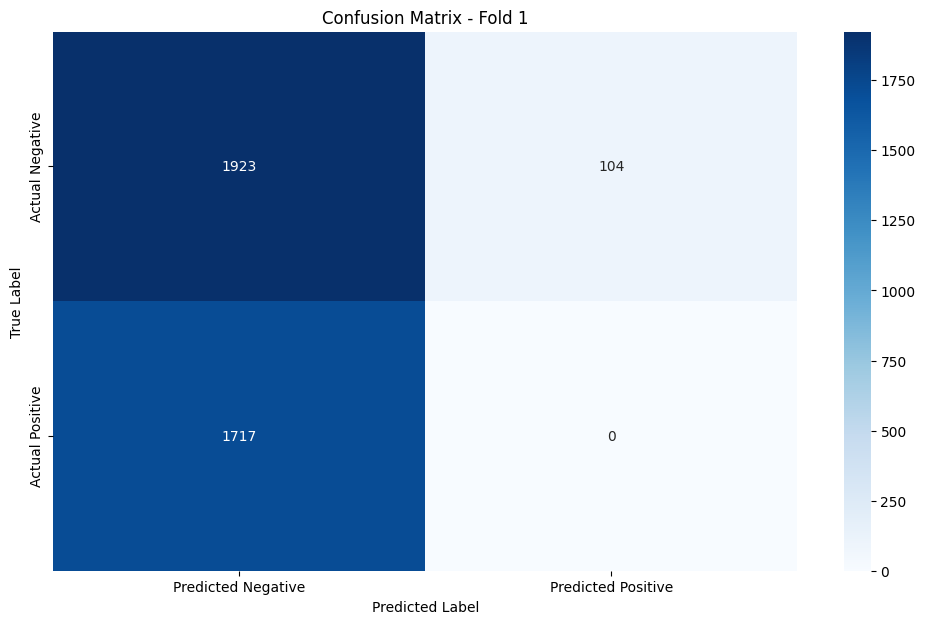

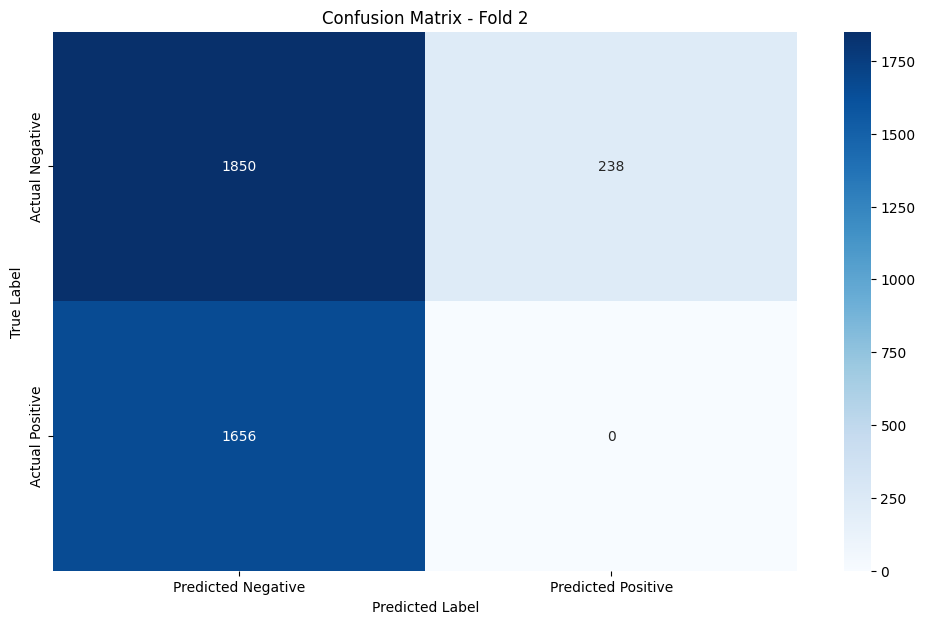

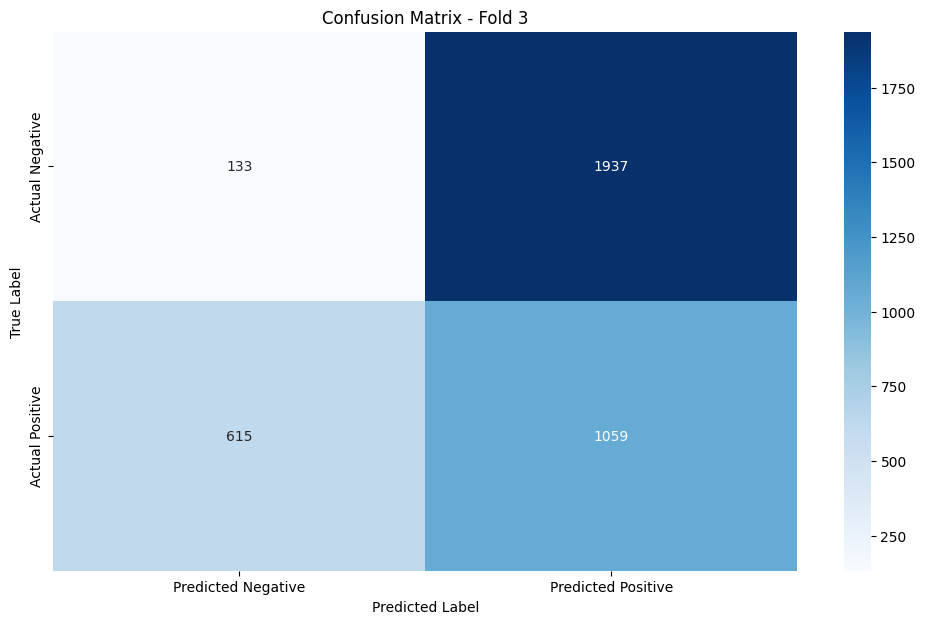

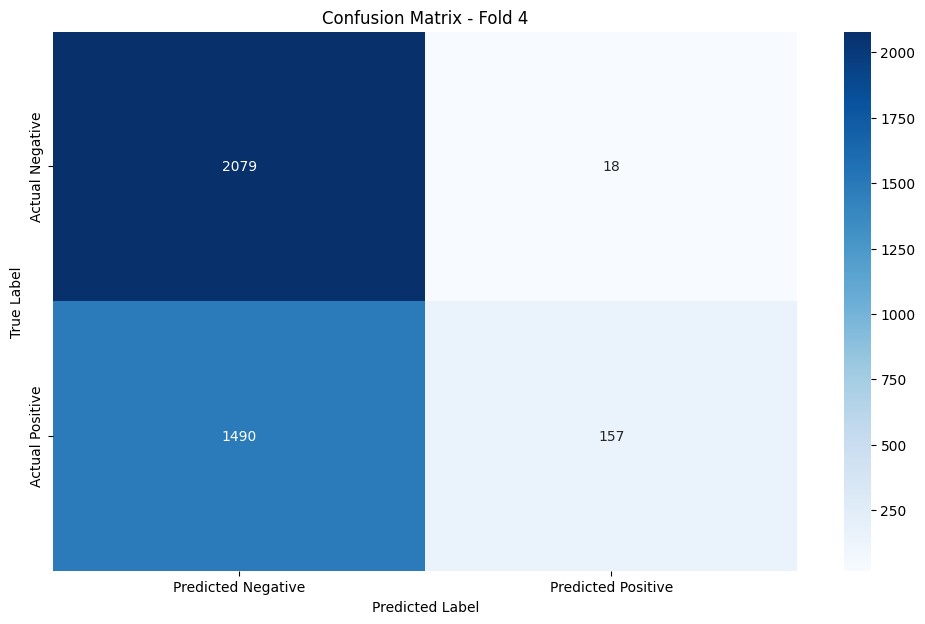

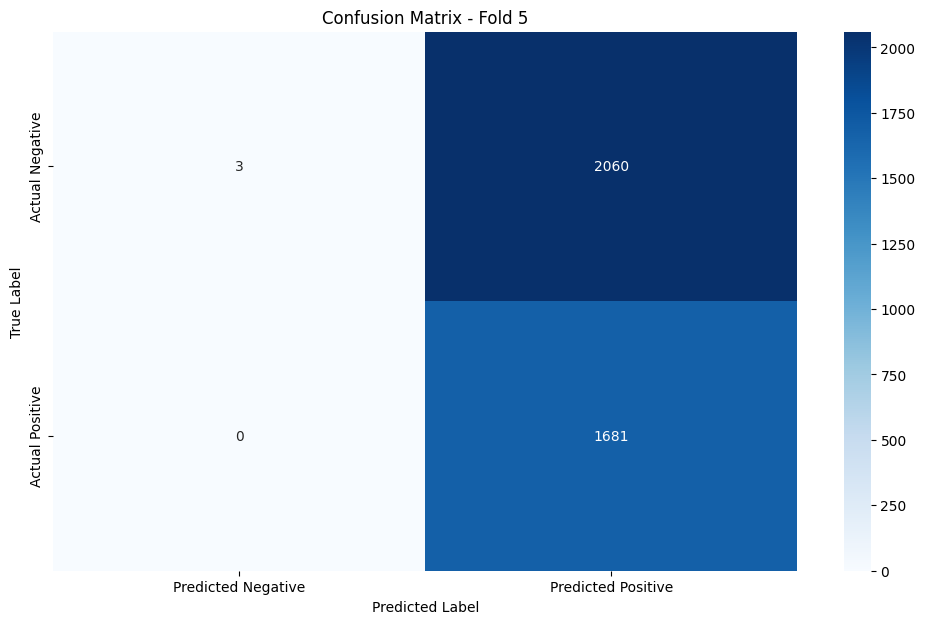

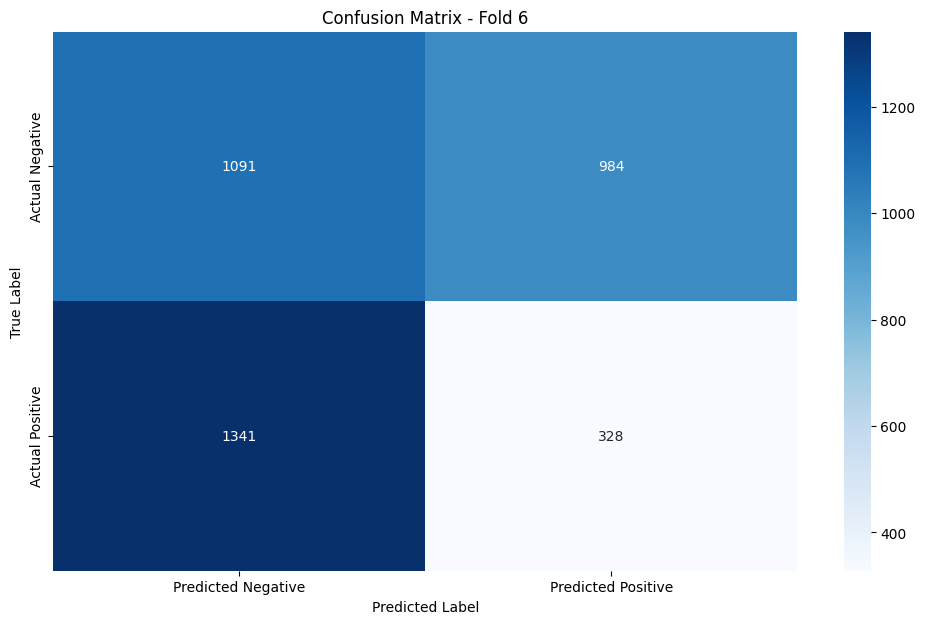

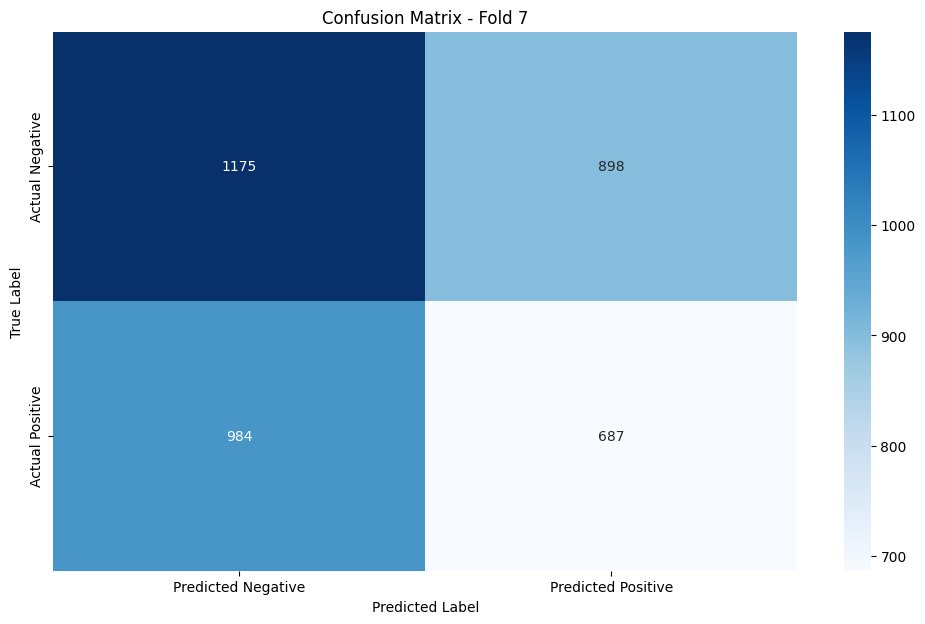

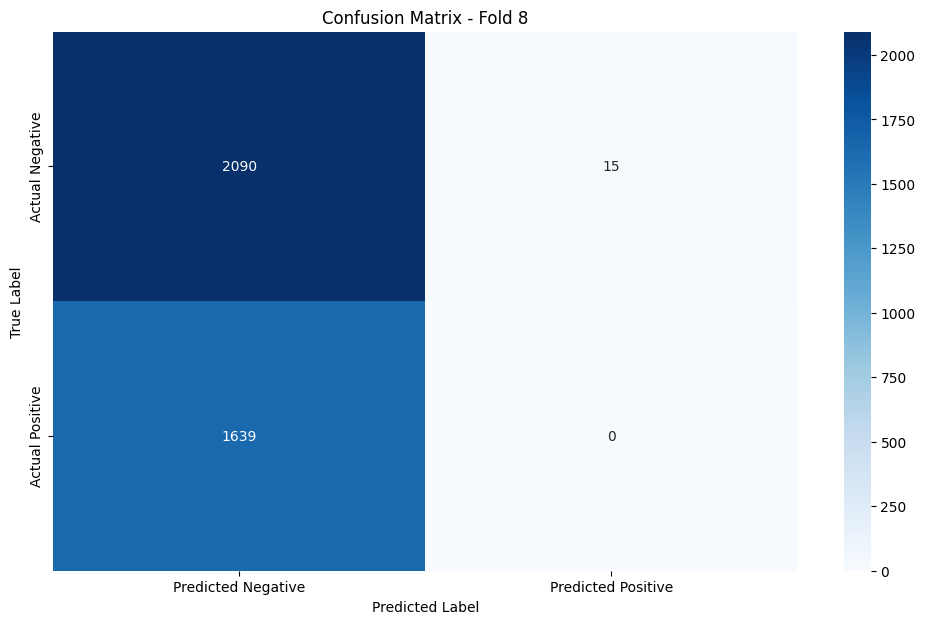

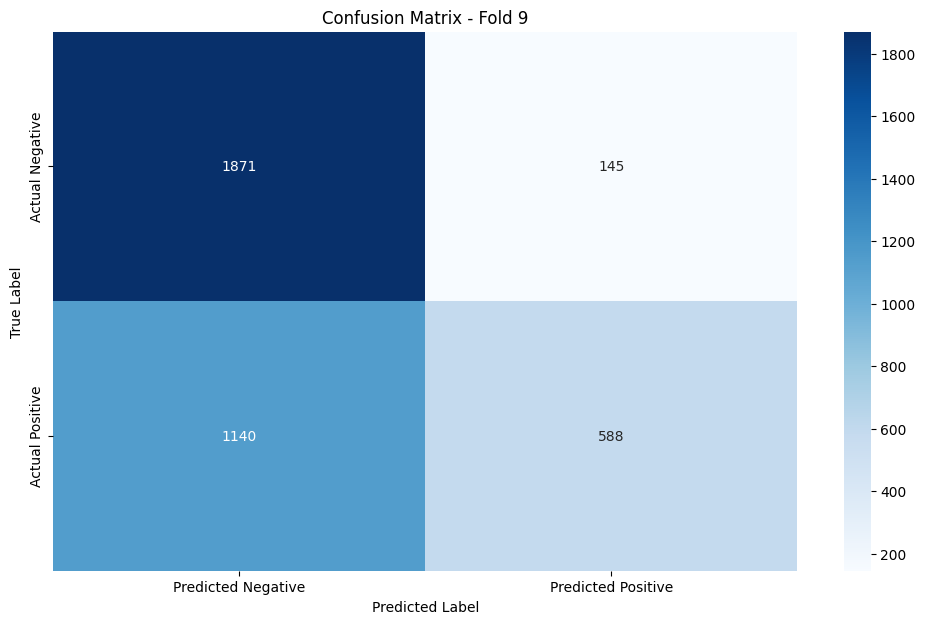

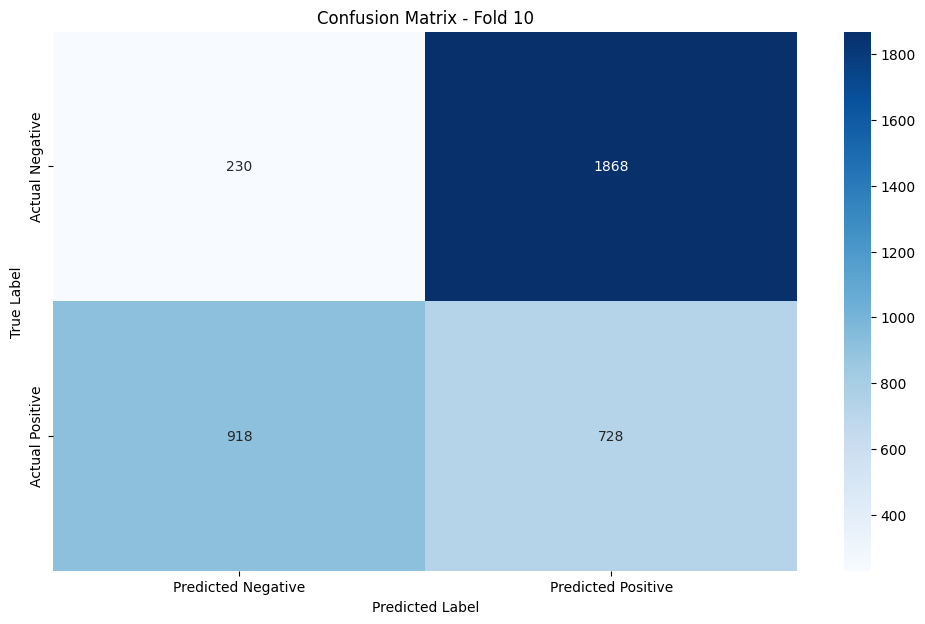

In [42]:
i = 0
for hexlist in best_hexid_per_kfold:
  new_hexlist = []
  for j in hexlist:
    temp = int(j)
    new_hexlist.append(temp)
  best_hexid_per_kfold[i] = new_hexlist
  i +=1

results = pd.DataFrame()
results['pred_y'] = best_all_pred_per_kfold[0][0]
results['actual_y'] = best_all_actual_per_kfold[0][0]
results

# model = NeuralNetwork()
# model.load_state_dict(torch.load("model.pth"))

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
confusion_per_k = []

for k in folds:
  mlcm = multilabel_confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
  print(f'=============== K = {k} ================')
  for cm in mlcm:
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]

    mcc = ((tn * tp) - (fn * fp)) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    f1 = tp / (tp + (0.5 * (fp + fn)))

  print(classification_report(best_actual_in_kfold[k], best_pred_in_kfold[k]))
  print('MCC: {}'.format(mcc))
  print('F1: {}'.format(f1))
    # if 0 accuracy is so bad, F1 is how much the predictions are right
    # might need to fix the amount under each label

def Average(lst):
  return sum(lst) / len(lst)

K = folds
# Get the index of the value 30
index_of_best_accuracy = batch_sizes.index(best_batch_size)

avg_accuracy = []
for i in outter_all_test_accuracy[index_of_best_accuracy]:
  avg = Average(i)
  avg_accuracy.append(avg)
print(avg_accuracy)

plt.bar(K, avg_accuracy, color ='darkblue', width = 0.6)
plt.xlabel("K-fold")
plt.ylabel("Average Accuracy")
plt.title(f"Region {region} RNN model: Average accuracy per K-fold for Batch Size {best_batch_size}")
plt.show()

for k in folds:
    cf_matrix = confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
    # Plot confusion matrix
    plt.figure(figsize=(12, 7))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Predicted Negative', 'Predicted Positive'],
               yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - Fold {k+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Candidate sites
> This section aims to look for potential optimal locations to put up RHUs. We will call these locations candidate sites. We will use the BP Neural Network that was trained in the section above to find these locations.

#### The results show that there are **2698 candidate sites**. Out of the 6487  locations, we were able to narrow this down to 41.5% of the Region's LOW ACCESSIBLE AREAS (6487) can have RHUs placed on them.

In [43]:
# Step 1: Load the saved model
modelpath = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/rnn_model.pt" # ⭐👑
candidatenn = RNN(input_size, hidden_size, output_size, best_batch_size).to(device)
candidatenn.load_state_dict(torch.load(modelpath))
candidatenn.eval()  # Set the model to evaluation mode

def low_k_fold_splitter(x,y,low_x,low_y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
  # actual labels for testing
  y_test = low_y
  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(low_x.values, dtype=torch.float)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(low_y.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = best_batch_size # ✈️ GO BACK TO THIS NEXT SEM - something u can optimize pa
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)
  return train_loader, test_loader, x_test_tensor, y_test

# global all_train_loss
all_train_loss = []
# global all_test_average_loss_values
all_test_average_loss_values  = []
# global all_test_accuracy
all_test_accuracy = []
# global all_pred_per_kfold
all_pred_per_kfold = []
# global all_actual_per_kfold
all_actual_per_kfold = []
# global actual_in_kfold
actual_in_kfold = []
# global pred_in_kfold
pred_in_kfold = []
# global hexid_per_kfold
hexid_per_kfold = []
best_accuracy = 0.0
modelpatience =20  # Number of epochs with no improvement to wait before stopping

for k in folds:
  train_loader, test_loader, x_test_tensor, y_test = low_k_fold_splitter(x_normalized, y_sample, filtered_low_accessible_x, filtered_labels_y)
  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []
  counter = 0  # Counter for consecutive epochs with no improvement
  prev_val_loss = float('inf')  # Initialize previous validation loss
  prev_accuracy = 0.0            # Initialize previous accuracy
  epochs = 100 ## change to best epoch pls
  print(f"=================== K = {k+1} ===================\n")

  for epoch in range(epochs):
      train(k,epoch,train_loader, candidatenn, criterion, optimizer)
      val_loss, val_accuracy = test(k,epoch,test_loader, candidatenn, criterion)
      if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          counter = 0 # Reset counter if there's improvement
      else:
          counter += 1
      if counter >= modelpatience:
          print(f'No improvement for {modelpatience} consecutive epochs. Stopping early.')
          break

  hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
  predictions, _ = model(x_test_tensor, hidden_state)
  predictions = F.softmax(predictions, dim=1)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)
  actual_y = y_test # actual y values per k-fold
  all_train_loss.append(train_loss_values)# loss
  all_test_average_loss_values.append(test_average_loss_values)# loss
  all_test_accuracy.append(test_accuracy_values) # accuracy
  actual_in_kfold.append(actual_y) # y pred and actual y
  all_pred_per_kfold.append(pred_in_kfold) # y pred and actual y
  all_actual_per_kfold.append(actual_y.tolist()) # y pred and actual y

  print("Done!")

=================== K = 1 ===================

loss: 0.692288  [    0/ 8735]
loss: 0.674076  [ 3200/ 8735]
loss: 0.666897  [ 6400/ 8735]
Fold: 1 | Epoch 1: | Loss: 0.644 | Acc: 92.428
loss: 0.697403  [    0/ 8735]
loss: 0.682044  [ 3200/ 8735]
loss: 0.689796  [ 6400/ 8735]
Fold: 1 | Epoch 2: | Loss: 0.644 | Acc: 92.428
loss: 0.663463  [    0/ 8735]
loss: 0.672483  [ 3200/ 8735]
loss: 0.689761  [ 6400/ 8735]
Fold: 1 | Epoch 3: | Loss: 0.644 | Acc: 92.428
loss: 0.690739  [    0/ 8735]
loss: 0.687381  [ 3200/ 8735]
loss: 0.681125  [ 6400/ 8735]
Fold: 1 | Epoch 4: | Loss: 0.644 | Acc: 92.428
loss: 0.688675  [    0/ 8735]
loss: 0.680263  [ 3200/ 8735]
loss: 0.674165  [ 6400/ 8735]
Fold: 1 | Epoch 5: | Loss: 0.644 | Acc: 92.428
loss: 0.684011  [    0/ 8735]
loss: 0.677270  [ 3200/ 8735]
loss: 0.675799  [ 6400/ 8735]
Fold: 1 | Epoch 6: | Loss: 0.644 | Acc: 92.428
loss: 0.689607  [    0/ 8735]
loss: 0.689168  [ 3200/ 8735]
loss: 0.659848  [ 6400/ 8735]
Fold: 1 | Epoch 7: | Loss: 0.644 | Acc: 9

In [44]:
# results['hex_id'] = hexid_per_kfold[0]
results = pd.DataFrame()
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

# candidates = pd.concat([results, y_filtered_labels_id], axis=1)
# candidates = candidates.drop(['index'], axis=1)
print(results[results['pred_y'] == 1])
print(y_filtered_labels_id)

# Reset index of both DataFrames
y_filtered_labels_id.reset_index(drop=True, inplace=True)
results.reset_index(drop=True, inplace=True)

# Merge the DataFrames side by side
merged_df = pd.concat([y_filtered_labels_id, results], axis=1)

# Display the merged DataFrame
print(merged_df)

candidates = merged_df[merged_df['pred_y'] == 1]
candidate_sites = candidates
len(candidate_sites)

all = len(results)
print(all)
buildable = len(candidate_sites)
print(buildable)
build_rhu_landscape = buildable/all
print(build_rhu_landscape) # this tells us how much of the area is a candidate site

# Export the dataset
save_dir = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}"
# hex_neighbors.to_csv(save_dir + '/Neighbors.csv', index=False)
candidate_sites.to_csv(save_dir + '/candidate_sites.csv', index=False)
filtered_low_accessible_df.to_csv(save_dir + '/PCF_data.csv', index=False)

      pred_y  actual_y
0          1         0
1          1         0
2          1         0
3          1         0
6          1         0
...      ...       ...
6830       1         0
6831       1         0
6832       1         0
6833       1         0
6841       1         0

[1416 rows x 2 columns]
           ID  Cluster
0     2937258        0
1     2938639        0
2     2938640        0
3     2938641        0
4     2939947        0
...       ...      ...
8031  3060187        0
8032  3061563        0
8033  3061564        0
8034  3061565        0
8035  3061566        0

[6854 rows x 2 columns]
           ID  Cluster  pred_y  actual_y
0     2937258        0       1         0
1     2938639        0       1         0
2     2938640        0       1         0
3     2938641        0       1         0
4     2939947        0       0         0
...       ...      ...     ...       ...
6849  3060187        0       0         0
6850  3061563        0       0         0
6851  3061564        0       

# PCF calculations
**Goal:** Get the buildable areas with their populations

**Remember, we want to target areas with HIGH POPULATION and LIMITED to NO RHU ACCESS!**

#### ***Recommended number of facilities is 0 for Region CAR.***
dont forget you will be using this value in optimize-2 when you get the optimal number of facilities


In [ ]:
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['Cluster'] == 1], inplace = True)
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['popden_all'] == 0], inplace = True)

hex_with_rhu = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
hex_with_rhu
buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 1]
buildable
non_buildable.shape # (5292, 23)
buildable.shape # (2216, 24)

(5565, 23)

In [ ]:
high_clustered = buildable[buildable['Cluster'] == 1]
high_clustered[high_clustered['buildability_landcov'] == 1] # look for buildable areas in high clustered areas
high_clustered[high_clustered['buildability_landcov'] == 0] # look for non buildable areas in high clustered areas
high_clustered['buildability_landcov'].unique() # looking for unique values. If its one, all places in this df are buiildable for RHUs

# df with RHUs + df with buildable areas == SABLAYAN
# using this to compute for the total population
frames = [hex_with_rhu, rg1n_clustered_df]
rg1_PCF_df = pd.concat(frames)
rg1_PCF_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
100,100,2945473,Labaan,San Quintin,Abra,1.316676,0.086427,1.328766,0,1,...,0.000000,60.755378,69.986885,745.277266,369.171842,184.473551,147.041397,0.395150,0,745.277266
266,266,2949695,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0,1,...,0.000000,1064.043944,461.590338,9934.919310,4948.307374,2839.042008,2127.815156,0.536488,0,9934.919310
267,267,2949696,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0,1,...,0.000000,177.832150,87.036106,1673.199458,825.388536,465.459534,358.513692,0.464459,0,1673.199458
401,401,2952458,Camdas Subdivision,City of Baguio,Benguet,0.211514,1.075451,0.748432,0,1,...,0.000000,3281.737645,2094.145067,35223.939879,18052.295636,10667.293964,8003.527819,0.518334,0,35223.939879
479,479,2953840,Abanao-Zandueta-Kayong-Chugum-Otek (AZKCO),City of Baguio,Benguet,0.203671,1.103190,0.750000,0,1,...,0.000000,2398.091662,1863.104340,31530.203824,16465.908709,10578.946669,9411.051527,0.518680,0,31530.203824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8031,8031,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,...,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8032,8032,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,...,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0,12.261030
8033,8033,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0,26.974266
8034,8034,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,...,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0,22.014504


In [ ]:
rg1_PCF_df.reset_index(drop=True, inplace=True)
rg1_PCF_df.drop(columns=['Unnamed: 0'], inplace=True)
total_rgn1_population = 0
def PCF(total_population):
  PCF = total_population / 20000
  return int(PCF)

In [ ]:
a = 1.65 # or 13042??
pd = rg1_PCF_df['popden_all']
rg1_PCF_df['total_population'] = pd * a
rg1_PCF_df

,ID,barangay_name,city_name,province_name,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,Road_Presence,...,Distance_to_Nearest_RHU_km,popden_chi,popden_eld,popden_all,popden_wom,popden_w_1,popden_you,HCFAI,Cluster,total_population
0,2945473,Labaan,San Quintin,Abra,1.316676,0.086427,1.328766,0,1,0,...,0.000000,60.755378,69.986885,745.277266,369.171842,184.473551,147.041397,0.395150,0,1229.707489
1,2949695,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0,1,1,...,0.000000,1064.043944,461.590338,9934.919310,4948.307374,2839.042008,2127.815156,0.536488,0,16392.616862
2,2949696,Asin Road,City of Baguio,Benguet,0.219790,1.087765,0.772923,0,1,0,...,0.000000,177.832150,87.036106,1673.199458,825.388536,465.459534,358.513692,0.464459,0,2760.779106
3,2952458,Camdas Subdivision,City of Baguio,Benguet,0.211514,1.075451,0.748432,0,1,1,...,0.000000,3281.737645,2094.145067,35223.939879,18052.295636,10667.293964,8003.527819,0.518334,0,58119.500800
4,2953840,Abanao-Zandueta-Kayong-Chugum-Otek (AZKCO),City of Baguio,Benguet,0.203671,1.103190,0.750000,0,1,1,...,0.000000,2398.091662,1863.104340,31530.203824,16465.908709,10578.946669,9411.051527,0.518680,0,52024.836310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8049,3060187,Romualdez,Rizal (Liwan),Kalinga,0.796756,1.049184,1.303862,1,0,0,...,35.795511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0,0.000000
8050,3061563,Calaocan,Rizal (Liwan),Kalinga,0.928698,0.982442,1.309814,1,0,0,...,43.542730,1.536035,0.772565,12.261030,6.080525,3.181145,2.653980,0.460966,0,20.230700
8051,3061564,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,0,...,42.621524,3.379277,1.699643,26.974266,13.377155,6.998519,5.838756,0.462201,0,44.507539
8052,3061565,Santor,Rizal (Liwan),Kalinga,0.883437,1.023447,1.311747,1,0,0,...,41.284935,2.689638,1.304456,22.014504,10.725258,5.651336,4.948002,0.462201,0,36.323932


In [ ]:
rg1_PCF_df.columns
total_rgn1_population = rg1_PCF_df['total_population'].sum()
# total_rgn1_population = rg1_PCF_df['popden_all'].sum()
print(round(total_rgn1_population, 2))
print(PCF(total_rgn1_population))

3579239.07
178
